In [1]:
# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
# pd.plotting.register_matplotlib_converters()
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import datetime
from sklearn.ensemble import IsolationForest
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from pylab import rcParams

In [2]:
# Read data
df = pd.read_csv('train_1.csv')

# Fill missing values
df = df.fillna(0)

In [3]:
# Reshaping the dataframe
df_reshaped = pd.melt(df,id_vars=['Page'],var_name='Date',value_name='Views')

In [4]:
# Setting 'Date' column as the index 
df_reshaped['Date'] = pd.DatetimeIndex(df_reshaped['Date'])
df_reshaped = df_reshaped.set_index('Date')

In [5]:
top_page_df = df_reshaped[df_reshaped.Page == 'Main_Page_en.wikipedia.org_all-access_all-agents']
top_page_df = top_page_df[['Views']]
top_page_df['Views'] = top_page_df['Views'].div(1000000).round(2)
top_page_df.head()

,Views
Date,
2015-07-01,20.38
2015-07-02,20.75
2015-07-03,19.57
2015-07-04,20.44
2015-07-05,20.77


## Anomaly detection

In [6]:
isolation_forest_model = IsolationForest(contamination=0.08)
isolation_forest_model.fit(top_page_df)
top_page_df['anomaly'] = isolation_forest_model.predict(top_page_df)

top_page_df['new_views'] = top_page_df.apply(lambda row: row.Views if row.anomaly == 1 else None, axis='columns')
top_page_df = top_page_df.assign(rolling_mean=top_page_df.new_views.fillna(top_page_df.new_views.rolling(30,min_periods=1).mean()))
top_page_df = top_page_df.drop(columns=['Views','anomaly','new_views']).rename(columns={'rolling_mean':'Views'})

In [7]:
## Convert dataset into suitable form to train the model
train = top_page_df[:'2016-09']
test = top_page_df['2016-10':]

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 7

X_train, y_train = create_dataset(train, train.Views, time_steps)
X_test, y_test = create_dataset(test, test.Views, time_steps)

In [15]:
n_features=1
model = keras.Sequential()
model.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(time_steps, n_features)))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

In [16]:
## Training the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    verbose=1,
    shuffle=False
)

Train on 451 samples
Epoch 1/20
451/451 [==============================] - 15s 34ms/sample - loss: 88.6404
Epoch 2/20
451/451 [==============================] - 0s 462us/sample - loss: 9.0421
Epoch 3/20
451/451 [==============================] - 0s 344us/sample - loss: 3.5139
Epoch 4/20
451/451 [==============================] - 0s 226us/sample - loss: 2.5881
Epoch 5/20
451/451 [==============================] - 0s 224us/sample - loss: 2.3567
Epoch 6/20
451/451 [==============================] - 0s 224us/sample - loss: 2.2684
Epoch 7/20
451/451 [==============================] - 0s 235us/sample - loss: 2.2229
Epoch 8/20
451/451 [==============================] - 0s 231us/sample - loss: 2.1978
Epoch 9/20
451/451 [==============================] - 0s 215us/sample - loss: 2.1781
Epoch 10/20
451/451 [==============================] - 0s 221us/sample - loss: 2.1571
Epoch 11/20
451/451 [==============================] - 0s 228us/sample - loss: 2.1361
Epoch 12/20
451/451 [====================

In [20]:
# Predictions using LSTM
y_pred = model.predict(X_test)

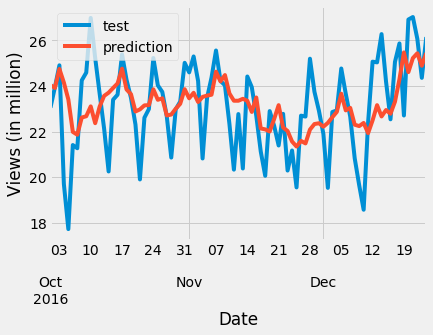

In [21]:
fig,ax=plt.subplots()
pd.DataFrame({'Date':test.index[:y_test.shape[0]],'Views':y_test}).plot('Date',ax=ax)
pd.DataFrame({'Date':test.index[:y_pred.shape[0]],'Views':y_pred.flatten()}).plot('Date',ax=ax)
plt.legend(['test', 'prediction'], loc='upper left')
plt.ylabel('Views (in million)')
plt.show()

In [22]:
print('RMSE:'+str(np.sqrt(np.mean(np.square(y_pred.flatten() - y_test)))))

RMSE:1.768301185903062
